In [376]:
import sys
sys.path.append('..')
from exchanger.parts import *
from exchanger.stream import *
from exchanger.exchanger import*
from exchanger.network import*
from exchanger.exchanger_types import*
from exchanger.network import vis_setups

import numpy as np
from numpy import exp


Die Stromführung des Wärmeübertragers besteht aus zwei inneren und zwei äußeren Durchgängen mit einer mantelseitigen Umlenkung. Die für die Wärmeübertragung maßgebende Größe $k A$ ist für alle Zellen gleich und beträgt $4 000 W/K$. Der Strom im Außenraum hat den Index 1. Um die Berechnung zu vereinfachen, werden die beiden Wärmekapazitätsströme $\dot{W_1}$ und $\dot{W_2}$ mit $3500 W/K$ gleich groß gewählt. Die Eintrittstemperatur des Stromes 1 ist $\vartheta^{'}_1 = 100 °C$ und die des Stromes 2 ist $\vartheta^{'}_2 = 20 °C$.

Zu bestimmen sind die Austrittstemperaturen $\vartheta^{'}_1$ und $\vartheta^{'}_2$.

<img src="./images/heatexchanger_network_equal.PNG" alt="heatexchanger_network_equal" width="650" height="300">

Zunächst werden die Fluidströme, im folgenden beispielsweise Wasser, definiert. Der Massenstrom wird dabei so angepasst dass die Wärmekapazitätsströme den in der Angabe vorgegebenen entsprechen. Der Druck für das Fluid wird so angepasst das es zu keiner Phasenänderung kommt um eine korrekte Berechnung zu gewährleisten.

In [377]:
W_dot_1 = 3500
fluid_1 = Fluid("Water", pressure=101420, temperature=273.15 + 100)
flow_1 = Flow(fluid_1, W_dot_1/fluid_1.specific_heat)
flow_1

Flow: id = 2284377432464
	mass flow = 0.83024 kg/s
	heat capacity flow: W_dot = 3500.00000 W/K
	heat flow: Q_dot = 0.00000 kW

Input Fluid:
	Fluid: title = Water, id = 2284378321872
	p = 101420 Pa
	t = 100.0 °C
Output Fluid:
	Fluid: title = Water, id = 2284413463504
	p = 101420 Pa
	t = 100.0 °C

In [378]:
W_dot_2 = 3500
fluid_2 = Fluid("Water", temperature=273.15 + 20)
flow_2 = Flow(fluid_2, W_dot_2/fluid_2.specific_heat)
flow_2

Flow: id = 2284377686352
	mass flow = 0.83651 kg/s
	heat capacity flow: W_dot = 3500.00000 W/K
	heat flow: Q_dot = 0.00000 kW

Input Fluid:
	Fluid: title = Water, id = 2284359716560
	p = 101325 Pa
	t = 20.0 °C
Output Fluid:
	Fluid: title = Water, id = 2284376886416
	p = 101325 Pa
	t = 20.0 °C

In [379]:
flows = [flow_1, flow_2]
network = ExchangerNetwork(flows)

Um die Austrittstemperaturen mithilfe der Zellenmethode zu berechnen muss die Chacharketristk des Netzwerks bekannt sein. Dazu können beisieplsweise die Matrizen die das Netzwerk beschreiben direkt definiert werden:

Zunächst können die dimensionslosen Kennzahlen des gesamten Netzwerks berechnet werden. Für die einzelnen Zellen wird davon ausgegangen dass sich die Wärmeübertragungsfähigkeit gleichmäßig auf die Zellen aufteilt.

In [380]:
R_1 = W_dot_1/W_dot_2
R_2 = W_dot_2/W_dot_1
display(f"R_1 = {R_1}, R_2 = {R_2}")

'R_1 = 1.0, R_2 = 1.0'

In [381]:
kA = 4000
cells = 4
NTU_1_ges = kA/W_dot_1
NTU_2_ges = kA/W_dot_2
NTU_1_cell = NTU_1_ges/cells
NTU_2_cell = NTU_2_ges/cells
display(f"NTU_1_cell = {NTU_1_cell}, NTU_2_cell = {NTU_2_cell}")

'NTU_1_cell = 0.2857142857142857, NTU_2_cell = 0.2857142857142857'

Es wird angenommen dass eine Zelle durch einen Wärmeübertrager mit einer Rohrreihe und mantelseitigen Krezstrom angenährt werden kann.

In [382]:
P_1_cell = 1 - exp((exp(-R_1 * NTU_1_cell) - 1) / R_1)

P_2_cell = R_1*P_1_cell

display(f"P_1_cell = {P_1_cell}, P_2_cell = {P_2_cell}")

'P_1_cell = 0.22004784968070001, P_2_cell = 0.22004784968070001'

Mit diesen Parametern können nun die Matrizen definiert werden.

In [383]:
network.phi_matrix = np.array([[1-P_1_cell, 0., 0., 0., P_1_cell, 0., 0., 0.],
                               [0., 1-P_1_cell, 0., 0., 0., P_1_cell, 0., 0.],
                               [0., 0., 1-P_1_cell, 0., 0., 0., P_1_cell, 0.],
                               [0., 0., 0., 1-P_1_cell, 0., 0., 0., P_1_cell],
                               [P_2_cell, 0., 0., 0., 1-P_2_cell, 0., 0., 0.],
                               [0., P_2_cell, 0., 0., 0., 1-P_2_cell, 0., 0.],
                               [0., 0., P_2_cell, 0., 0., 0., 1-P_2_cell, 0.],
                               [0., 0., 0., P_2_cell, 0., 0., 0., 1-P_2_cell]])
network.structure_matrix = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 0, 0, 0, 0],
                                     [1, 0, 0, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 1, 0, 0, 0],
                                     [0, 0, 0, 0, 0, 1, 0, 0],
                                     [0, 0, 0, 0, 0, 0, 1, 0]])
network.input_matrix = np.array([[0, 0],
                                 [0, 0],
                                 [1, 0],
                                 [0, 0],
                                 [0, 1],
                                 [0, 0],
                                 [0, 0],
                                 [0, 0]])
network.output_matrix = np.asarray([[0, 0, 0, 1, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 1]])

Für die einzelnen Zellen ergeben sich somit die folgenden Austritsstemperaturen.

In [384]:
network.temperature_matrix[1]-273.15

array([[63.32779554],
       [75.5518637 ],
       [87.77593185],
       [61.86324704],
       [32.22406815],
       [44.4481363 ],
       [56.67220446],
       [58.13675296]])

Durch die Outputmatirx können noch zusätzlich die Austrittstemperaturen aus dem gesamten Netzwerk herausgefiltert bzw. berechnet werden.

In [385]:
network.temperature_outputs[1]-273.15

array([[61.86324704],
       [58.13675296]])

Wie sich zeigt ist die Definiton der Matrizen für die Zellenmethode nicht immer einfach. Deshalb kann die Berechnung eines Netzwerk mit zwei Strömen und gleichmäßiger Aufteilung der Wärmeübertragungsfähigkeit auf die einzelnen Zellen, wei folgt durchgeführt werden.

In [386]:
W_dot_1 = 3500
fluid_1 = Fluid("Water", pressure=101420, temperature=273.15 + 100)
flow_1 = Flow(fluid_1, W_dot_1/fluid_1.specific_heat)

W_dot_2 = 3500
fluid_2 = Fluid("Water", temperature=273.15 + 20)
flow_2 = Flow(fluid_2, W_dot_2/fluid_2.specific_heat)

In [387]:
kA = 4000
ex = ExchangerEqualCells((2, 2), 'CrossFlowOneRow', flow_1=flow_1, flow_order_1 = 'dr2u', flow_2=flow_2,flow_order_2 = 'ul2r', total_transferability=kA)

Wie zu sehen ist ergeben sich wieder die gleichen Austrittstemperaturen wie bei der dirketen eingabe der Matrizen. Die geringe Abweichung kommt dadurch zustande dass die Berechnung iterativ erfolgt und die Austrittstemperaturen bzw die Fluiddaten und somit auch die dimensionslosen Kennzahlen der Zellen angepasst werden. 

In [388]:
print(ex.extended_info())

Heat Exchanger Network:
	cell numbers: 4
	heat flows q_1=133.56 kW,	q_2=-133.56 kW
input flows: n=2
	flow 0: Water, temp= 100.00°C
	flow 1: Water, temp= 20.00°C
output flows: n=2
	flow 0: Water, temp= 62.18°C
	flow 1: Water, temp= 58.42°C

cell:0

heat exchanger:
	id = 2284414047312
	type: CrossFlowOneRow
Flows:
Flow 1:
Flow: id = 2284414047248
	mass flow = 0.83394 kg/s
	heat capacity flow: W_dot = 3510.12275 W/K
	heat flow: Q_dot = 42.61267 kW

Input Fluid:
	Fluid: title = Water, id = 2284414046800
	p = 101420 Pa
	t = 100.0 °C
Output Fluid:
	Fluid: title = Water, id = 2284414047440
	p = 101420 Pa
	t = 87.86043738378032 °C

Flow 2:
Flow: id = 2284414046480
	mass flow = 0.82769 kg/s
	heat capacity flow: W_dot = 3461.04439 W/K
	heat flow: Q_dot = -42.61240 kW

Input Fluid:
	Fluid: title = Water, id = 2284414048720
	p = 101325 Pa
	t = 44.616938608050646 °C
Output Fluid:
	Fluid: title = Water, id = 2284414047696
	p = 101325 Pa
	t = 56.928642847056494 °C

Parameters:

dimensionless paramete

Um den Einfluss der Fluidparamter auf die Ausgangstemperatur zu visualisieren kann der folgende Plot hearngezogen werden. Es zeigt sich dass nach einer iteration, dh anpassen der Zelltemperaturen am Ein und Austritt der Zelle schon ausreichend genau sind und die Netzwerk ausgangstemperatur keine Signifikaten änderungen mehr erfährt.

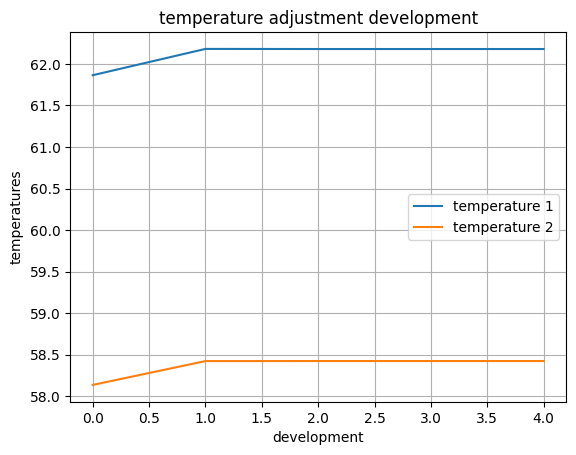

In [389]:
ex.vis_temperature_adjustment_development()

Zum Beurteilen der Effiktivität/ des Wirkungsgrads des Netzwerks kann der Temperaturverlauf der einzelnen Ströme oder der Umgesetzte Wärmestrom hilfreich sein. Es zeigt sich das sich in den ersten 3 Zellen die vom jeweiligen Strom durchlaufen werden gleicher Wärmestrom umgesetzt wird bzw die Temperaturänderung innerhalb einer Zelle gleich ist. In der letzten Zelle ist die Temperaturdifferenz zwischen den Strömen so gering dass nicht mehr so viel Wärmestrom übertragen wird.

Die Visualisierung des Temperaturverlaufes zeigt nur die Ein und Austrittstemperaturen an den Zellen. Der lineare Verlauf dazwischen entspricht nicht dem tatsächlichen Temperturverlauf innerhalb einer Zelle. Wird das Netzwerk jedoch mit einer größeren Anzahl von Zellen beschrieben könnnen auch die realen Temepraturverläufe wie sie etwa bei reinem Gleich oder Gegenstrom auftreten nachgeildet werden.

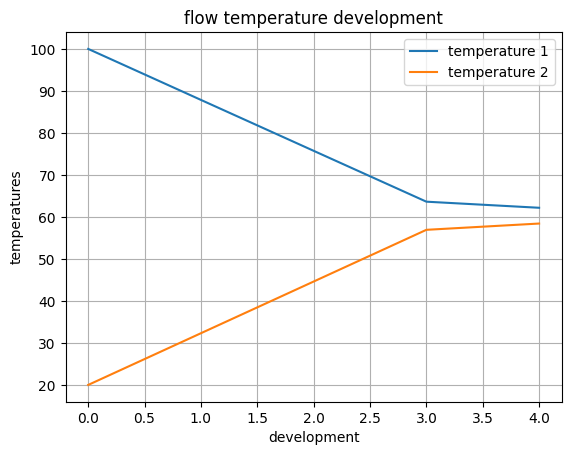

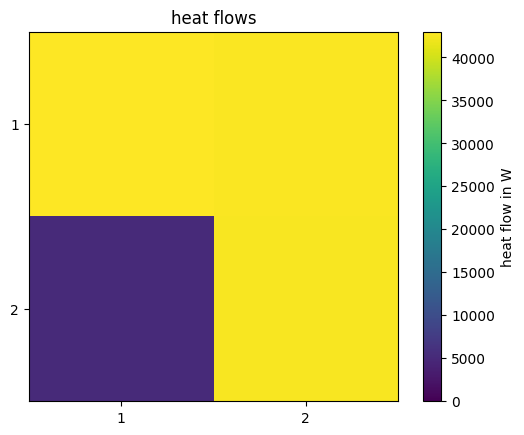

In [390]:
ex.vis_flow_temperature_development()
ex.vis_heat_flow()


Ist gefragt welche Ein und Austrittspositionen am Besten für die gebene Fluiddaten sind kann dies anhand folgender Daten beurteilt werden.

In [391]:
def init_ex():
    W_dot_1 = 3500
    fluid_1 = Fluid("Water", pressure=101420, temperature=273.15 + 100)
    flow_1 = Flow(fluid_1, W_dot_1/fluid_1.specific_heat)

    W_dot_2 = 3500
    fluid_2 = Fluid("Water", temperature=273.15 + 20)
    flow_2 = Flow(fluid_2, W_dot_2/fluid_2.specific_heat)

    kA = 4000
    ex = ExchangerEqualCells((2, 2), 'CrossFlowOneRow', flow_1=flow_1, flow_2=flow_2,total_transferability=kA)
    return ex

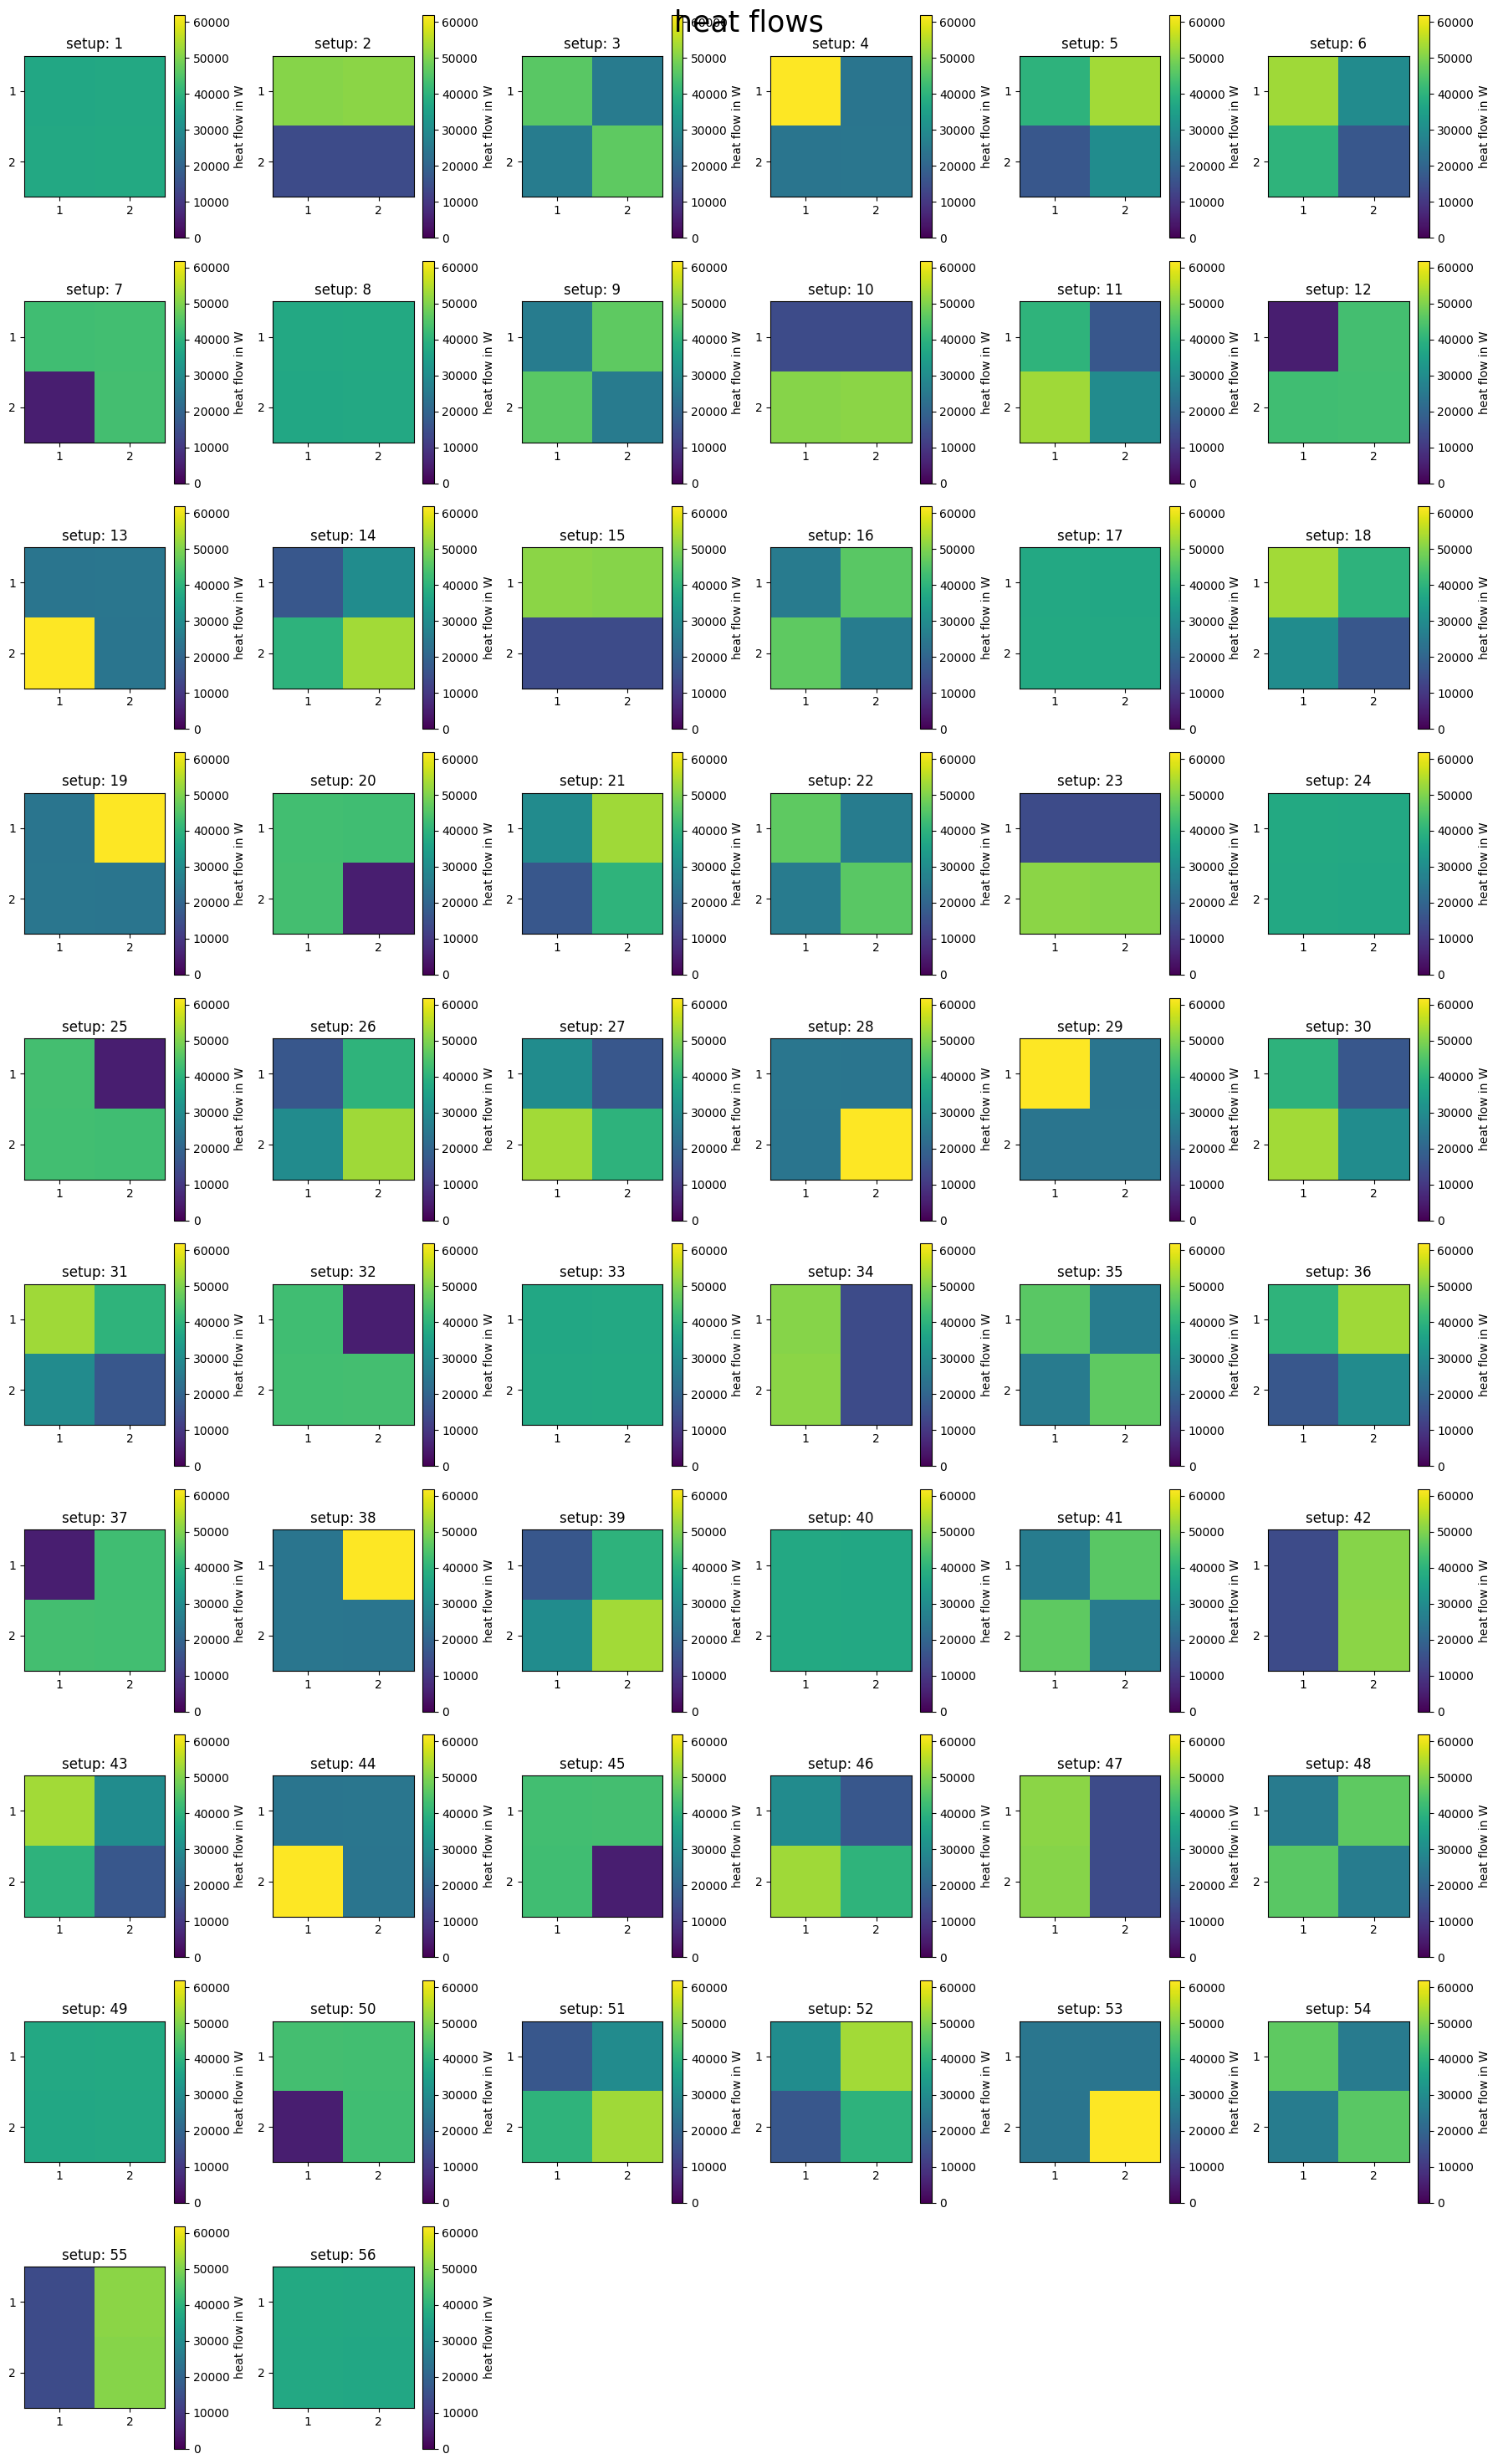

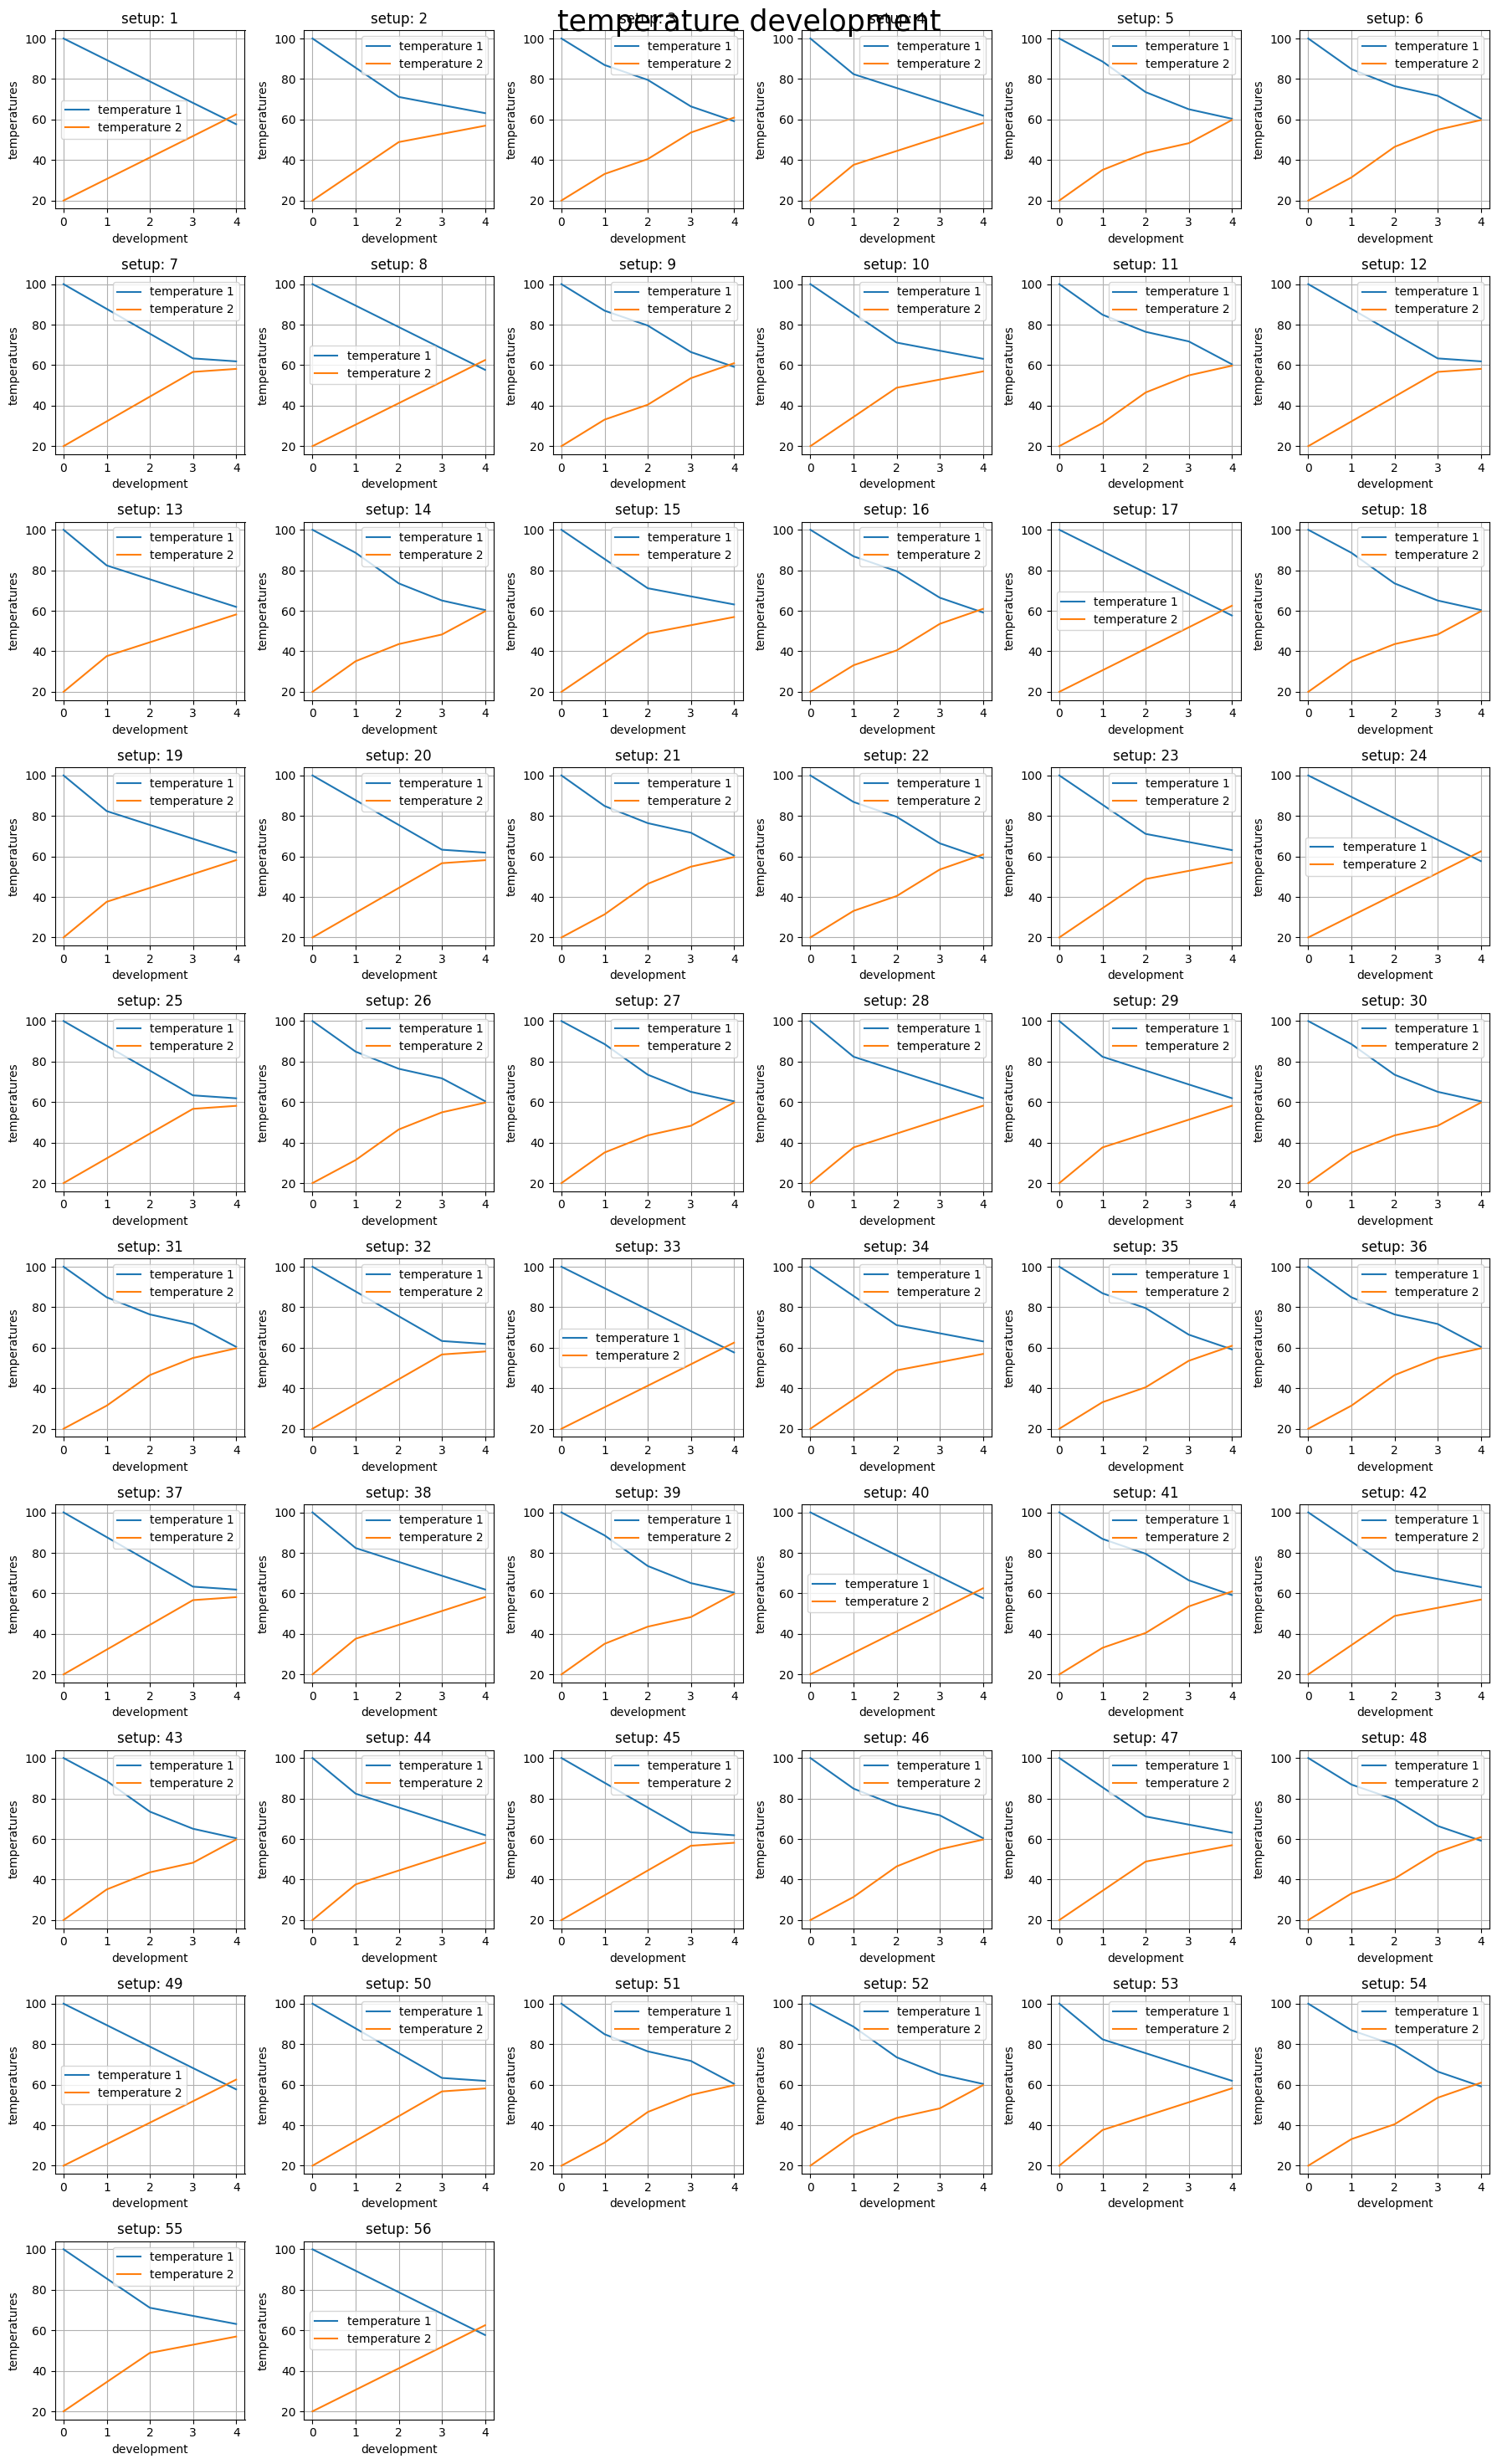

In [392]:
networks = []
for inp in ExchangerTwoFlow.input_arrangements():
    netw = init_ex()
    netw.flow_order_1 = inp[0]
    netw.flow_order_2 = inp[1]
    netw._adjust_temperatures()
    networks.append(netw)

ax_parameters_heat = {'vmin': 0, 'vmax': max([heat_flow_repr(netw.layout_matrix).max() for netw in networks])}
vis_setups(networks, 'vis_heat_flow', fig_title='heat flows', **ax_parameters_heat)
vis_setups(networks, 'vis_flow_temperature_development', fig_title='temperature development')

Es zeigt sich dass jene Setups in denen in jeder Zelle der gleiche Wärmestrom übertragen wird den höchsten wirkungsgrad haben, dh die Austrittstemperaturen die größte Temperaturdifferenz bezogen auf die Eintrittstemperaturen haben.